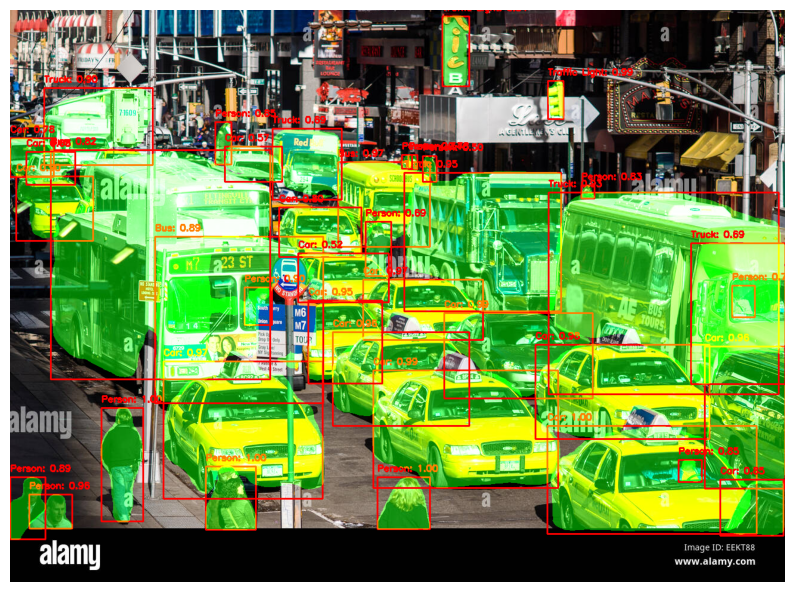

In [48]:
import torch
import torchvision   #Used for loading the Mask R-CNN model and performing deep learning inference.
from torchvision.transforms import functional as F
import cv2      ##: Used for reading and processing images.
import numpy as np
import matplotlib.pyplot as plt

# Load a pretrained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define COCO class labels (subset for visualization)
COCO_CLASSES = {1: "Person", 2: "Bicycle", 3: "Car", 4: "Motorcycle", 6: "Bus", 7: "Train", 8: "Truck",
                9: "Boat", 10: "Traffic Light", 11: "Fire Hydrant", 13: "Stop Sign", 14: "Parking Meter",
                15: "Bench", 16: "Bird", 17: "Cat", 18: "Dog", 19: "Horse", 20: "Sheep", 21: "Cow"}



# Load the input image
image_path = "/traffic-jam-with-many-vehicles-in-times-square-new-york-city-EEKT88.jpg"  # Change this to your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image_orig = image.copy()

# Convert image to tensor and add batch dimension
image_tensor = F.to_tensor(image).unsqueeze(0)      # Converts the image into a PyTorch tensor with pixel values scaled between [0, 1].

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

boxes = predictions[0]['boxes'].numpy()   #Bounding box coordinates for detected objects.
masks = predictions[0]['masks'].detach().numpy()    #Segmentation masks for objects (pixel-wise prediction).
labels = predictions[0]['labels'].numpy()      #Class IDs for each detected object.
scores = predictions[0]['scores'].numpy()       # Confidence scores for each detected object.

confidence_threshold = 0.5
indices = scores > confidence_threshold

filtered_boxes = boxes[indices]
filtered_masks = masks[indices]
filtered_labels = labels[indices]
filtered_scores = scores[indices]

for i in range(len(filtered_boxes)):
    box = filtered_boxes[i].astype(int)
    mask = filtered_masks[i][0] > 0.3  # Threshold mask
    label_id = filtered_labels[i]
    score = filtered_scores[i]

    label_name = COCO_CLASSES.get(label_id, "Unknown")

    # Draw bounding box
    cv2.rectangle(image_orig, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    cv2.putText(image_orig, f"{label_name}: {score:.2f}", (box[0], box[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Apply mask
    mask = mask.astype(np.uint8) * 255
    colored_mask = np.zeros_like(image_orig, dtype=np.uint8)
    colored_mask[:, :, 1] = mask  # Green mask
    image_orig = cv2.addWeighted(image_orig, 1, colored_mask, 0.5, 0)

# Display final segmented image
plt.figure(figsize=(10, 10))
plt.imshow(image_orig)
plt.axis("off")
plt.show()
